In [3]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from catboost import Pool
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
import copy
import warnings
warnings.filterwarnings('ignore')

In [6]:
ls drive/MyDrive/'Spaceship Titanic'/

sample_submission.csv  test.csv  train.csv


In [160]:
df_train = pd.read_csv('drive/MyDrive/Spaceship Titanic/train.csv')
df_test = pd.read_csv('drive/MyDrive/Spaceship Titanic/test.csv')
df_sample_submission = pd.read_csv('drive/MyDrive/Spaceship Titanic/sample_submission.csv')

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.


**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.


**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.


**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.


**Destination** - The planet the passenger will be debarking to.


**Age** - The age of the passenger.


**VIP** - Whether the passenger has paid for special VIP service during the voyage.


**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.


**Name** - The first and last names of the passenger.


Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [161]:
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [162]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [163]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [164]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [165]:
info_for_object = {}
for col in list(df_train.columns[df_train.dtypes.isin(["object"])]):
    mode_ = df_train[col].mode()[0]
    df_train[col].fillna(mode_, inplace=True)
    info_for_object[col] = mode_
    
info_for_numeric = {}
for col in list(df_train.select_dtypes('float64').columns):
    mean_ = df_train[col].mean()
    df_train[col].fillna(mean_, inplace=True)
    info_for_numeric[col] = mean_

df_train['Transported'] = df_train.Transported.astype('int64')
df_train['CryoSleep'] = df_train.CryoSleep.astype('bool').astype('int64')
df_train['VIP'] = df_train.VIP.astype('bool').astype('int64')

In [141]:
corr=df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
CryoSleep,1.000000,-0.070736,-0.078281,-0.243986,-0.205682,-0.206366,-0.198392,-0.193107,0.460132
Age,-0.070736,1.000000,0.091574,0.067612,0.127937,0.032655,0.120992,0.099210,-0.074249
VIP,-0.078281,0.091574,1.000000,0.056595,0.126006,0.018483,0.060573,0.123092,-0.037261
RoomService,-0.243986,0.067612,0.056595,1.000000,-0.015521,0.052962,0.009925,-0.019207,-0.242048
FoodCourt,-0.205682,0.127937,0.126006,-0.015521,1.000000,-0.013934,0.220587,0.224275,0.046074
ShoppingMall,-0.206366,0.032655,0.018483,0.052962,-0.013934,1.000000,0.013678,-0.007189,0.010019
Spa,-0.198392,0.120992,0.060573,0.009925,0.220587,0.013678,1.000000,0.147957,-0.218791
VRDeck,-0.193107,0.099210,0.123092,-0.019207,0.224275,-0.007189,0.147957,1.000000,-0.204825
Transported,0.460132,-0.074249,-0.037261,-0.242048,0.046074,0.010019,-0.218791,-0.204825,1.000000


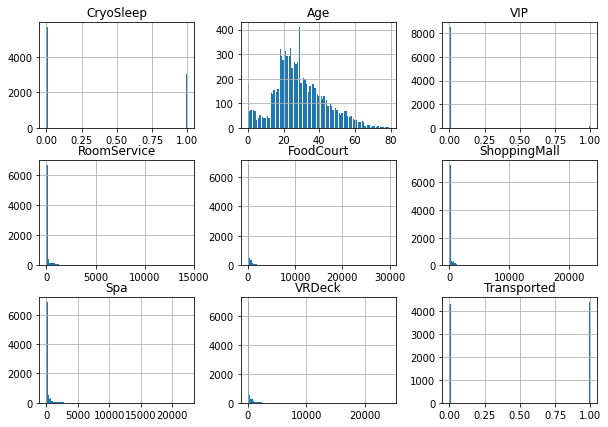

In [142]:
df_train.hist(figsize=(10,7),bins=110)
plt.show()

In [190]:
cb2 = CatBoostClassifier(task_type='CPU',
                       verbose=False)

parameters = {'depth': [3,6,8,10],
              'learning_rate' : [0.01,0.1,0.2],
              'iterations'    : [50,100,200]}

df = df_train.copy()
# for col in df.select_dtypes(include=['object']):
#     print(col)
#     df[col] = df[col].astype('category')

X=df.drop(['PassengerId', 'Name','Transported'], axis=1)
y=df.Transported.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

grid = GridSearchCV(estimator=cb2, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train,cat_features=list(X_train.columns[X_train.dtypes.isin(["object"])]))

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f951c615450>,
             n_jobs=-1,
             param_grid={'depth': [3, 6, 8, 10], 'iterations': [50, 100, 200],
                         'learning_rate': [0.01, 0.1, 0.2]})

In [191]:
grid.best_params_

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}

In [192]:
model2 = CatBoostClassifier(iterations=grid.best_params_['iterations'],
                           learning_rate=grid.best_params_['learning_rate'],
                           depth=grid.best_params_['depth'])

df = df_train.copy()
X=df.drop(['PassengerId', 'Name','Transported'], axis=1)
y=df.Transported.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
cat_features = list(X_train.columns[X_train.dtypes.isin(["object"])])

model2.fit(X_train, y_train, cat_features)

y_pred = model2.predict(X_test)

0:	learn: 0.6614469	total: 6.02ms	remaining: 596ms
1:	learn: 0.6355483	total: 12.3ms	remaining: 601ms
2:	learn: 0.6130455	total: 17.9ms	remaining: 578ms
3:	learn: 0.5945602	total: 23ms	remaining: 552ms
4:	learn: 0.5780216	total: 29.1ms	remaining: 554ms
5:	learn: 0.5648566	total: 34.1ms	remaining: 535ms
6:	learn: 0.5521102	total: 39.1ms	remaining: 520ms
7:	learn: 0.5415779	total: 44.5ms	remaining: 512ms
8:	learn: 0.5307810	total: 55.3ms	remaining: 560ms
9:	learn: 0.5206721	total: 68.7ms	remaining: 618ms
10:	learn: 0.5128528	total: 73.7ms	remaining: 597ms
11:	learn: 0.5048832	total: 79.7ms	remaining: 585ms
12:	learn: 0.4975726	total: 90.2ms	remaining: 604ms
13:	learn: 0.4916103	total: 95.3ms	remaining: 585ms
14:	learn: 0.4874021	total: 101ms	remaining: 573ms
15:	learn: 0.4828864	total: 106ms	remaining: 558ms
16:	learn: 0.4783087	total: 111ms	remaining: 544ms
17:	learn: 0.4747763	total: 116ms	remaining: 530ms
18:	learn: 0.4709068	total: 122ms	remaining: 520ms
19:	learn: 0.4680830	total: 1

In [193]:
f1_score(y_test,y_pred)

0.8153424657534247

In [194]:
accuracy_score(y_test,y_pred)

0.8062104657849338

In [168]:
df_test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [171]:
for col in list(df_test.columns[df_test.dtypes.isin(["object"])]):
    mode_ = info_for_object[col]
    df_test[col].fillna(mode_, inplace=True)
    
for col in list(df_test.select_dtypes('float64').columns):
    mean_ = info_for_numeric[col]
    df_test[col].fillna(mean_, inplace=True)

df_test['CryoSleep'] = df_test.CryoSleep.astype('bool').astype('int64')
df_test['VIP'] = df_test.VIP.astype('bool').astype('int64')

In [197]:
y_pred_rez = model2.predict(df_test.drop(['PassengerId', 'Name'], axis=1))

In [198]:
df_rez = pd.DataFrame(list(zip(df_test.PassengerId, y_pred_rez.astype('bool'))),
               columns =['PassengerId', 'Transported'])
df_rez

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [199]:
df_rez.to_csv('df_rez.csv', index=False)

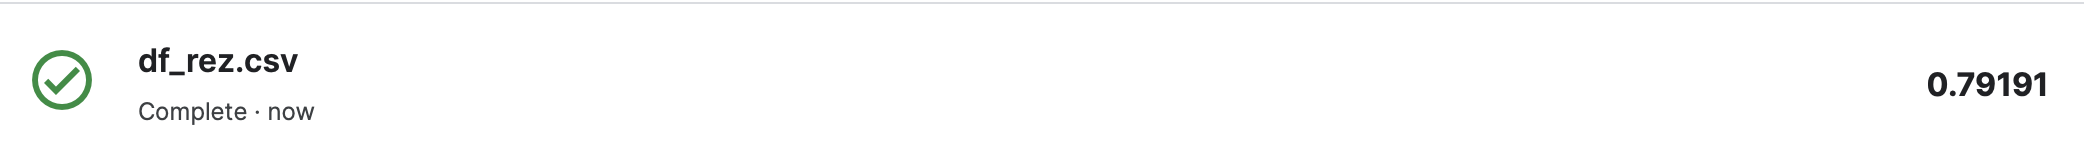

In [183]:
from sklearn.ensemble import RandomForestClassifier

In [200]:
df_rf = df_train.copy()

In [201]:
df_rf.groupby(['HomePlanet']).count()

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
HomePlanet,,,,,,,,,,,,,
Earth,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803,4803
Europa,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131,2131
Mars,1759,1759,1759,1759,1759,1759,1759,1759,1759,1759,1759,1759,1759


In [202]:
df_rf = pd.concat([df_rf,pd.get_dummies(df_rf['HomePlanet'],prefix='HomePlanet')], axis=1).drop('HomePlanet',axis=1)

In [204]:
df_rf.drop('HomePlanet_Mars', axis=1, inplace=True)

In [208]:
len(df_rf.Destination.unique())

3

In [209]:
df_rf.groupby(['Destination']).count()

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa
Destination,,,,,,,,,,,,,,
55 Cancri e,1800,1800,1800,1800,1800,1800,1800,1800,1800,1800,1800,1800,1800,1800
PSO J318.5-22,796,796,796,796,796,796,796,796,796,796,796,796,796,796
TRAPPIST-1e,6097,6097,6097,6097,6097,6097,6097,6097,6097,6097,6097,6097,6097,6097


In [ ]:
df_rf = pd.concat([df_rf,pd.get_dummies(df_rf['Destination'],prefix='Destination')], axis=1).drop('Destination',axis=1)

In [212]:
df_rf.drop('Destination_PSO J318.5-22', axis=1, inplace=True)

In [207]:
len(df_rf.Cabin.unique())

6560

In [215]:
from sklearn import preprocessing 

In [217]:
le = preprocessing.LabelEncoder()
le.fit(df_rf.Cabin)

LabelEncoder()

In [218]:
df_rf['Cabin'] = le.transform(df_rf.Cabin)

In [229]:
X=df_rf.drop(['PassengerId', 'Name','Transported'], axis=1)
y=df_rf.Transported

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

rf = RandomForestClassifier()

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=rf, param_grid = param_grid, cv = 5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [230]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [232]:
rf_ = RandomForestClassifier(
    n_estimators = grid.best_params_['n_estimators'],
    max_features = grid.best_params_['max_features'],
    max_depth = grid.best_params_['max_depth'],
    criterion = grid.best_params_['criterion'])

rf_.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500)

In [256]:
df_rf_test = df_test.copy()

In [257]:
df_rf_test = pd.concat([df_rf_test,pd.get_dummies(df_rf_test['HomePlanet'],prefix='HomePlanet')], axis=1).drop('HomePlanet',axis=1)
df_rf_test.drop('HomePlanet_Mars', axis=1, inplace=True)
df_rf_test = pd.concat([df_rf_test,pd.get_dummies(df_rf_test['Destination'],prefix='Destination')], axis=1).drop('Destination',axis=1)
df_rf_test.drop('Destination_PSO J318.5-22', axis=1, inplace=True)

list_cabin = []
max_class=np.max(df_rf['Cabin'])+1
for i in df_rf_test['Cabin']:
    if i in le.classes_:
        list_cabin.append(le.transform([i]))
    else:
        list_cabin.append(max_class)
        max_class+=1
        
df_rf_test['Cabin'] = list_cabin
X_for_test=df_rf_test.drop(['PassengerId', 'Name'], axis=1)

In [259]:
rf_y_pred = rf_.predict(X_for_test)

In [261]:
df_rez_rf = pd.DataFrame(list(zip(df_test.PassengerId, rf_y_pred.astype('bool'))),
               columns =['PassengerId', 'Transported'])
df_rez_rf

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [262]:
df_rez_rf.to_csv('df_rez_rf.csv', index=False)

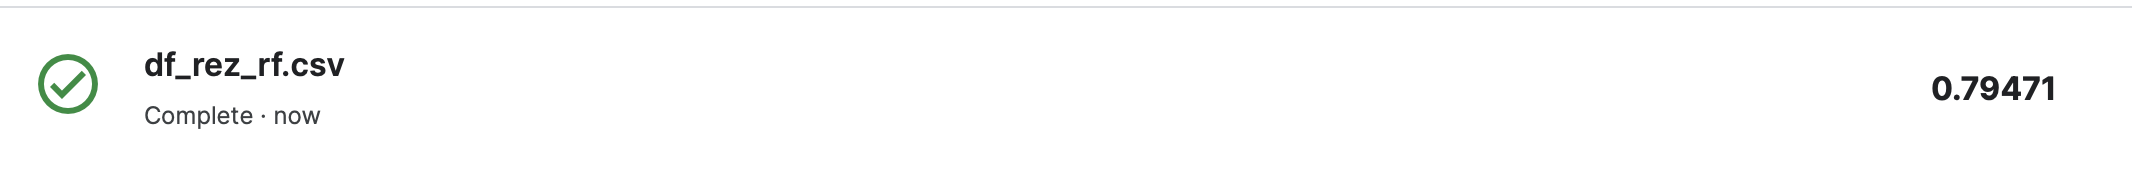